# Personal Protection Equipment Detection model
This notebook shows how you can use SageMaker Python API to do the following:
 * deploy our model to create an endpoint
 * run Real Time inference on endpoint using local image
 * visualize  and save the prediction on original image
 * run Batch Transform job to perfom the inference on your data stored in Amazon S3 bucket

### 1. Start the trial or buy our VitechLab PPE model on AWS Marketplace

You can find our model here: https://aws.amazon.com/marketplace/pp/prodview-6gvzwuebead3o

### 2. Initializing a model using AWS SageMaker Python API

In [2]:
import sagemaker as sage
from sagemaker import get_execution_role

sess = sage.Session()
role = get_execution_role()

In [3]:
from utils import get_model_package_arn

model_package_arn = get_model_package_arn(sess.boto_region_name)

model = sage.ModelPackage(
    role=role,
    model_package_arn=model_package_arn)

### 3. Generating Prediction using `RealTimePredictor`

#### Creating a new endpoint

In [5]:
endpoint_name='ppe-model-example-endpoint'

model.deploy(initial_instance_count=1, instance_type='ml.m4.2xlarge', endpoint_name=endpoint_name)

--------------------------------------------------------------------------------------------------------------------!

#### Generating predictions

In [6]:
predictor = sage.predictor.RealTimePredictor(
    endpoint_name,
    sagemaker_session=sess, 
    content_type="image/jpeg"
)

In [7]:
file_name = 'data/test_samples/demo_input/54_11.Welder_in_Egypt_(...jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    image_bytes = bytearray(f)

prediction_result = predictor.predict(image_bytes).decode("utf-8")

In [17]:
import json

result = json.loads(prediction_result)
result

[[73.0, 226.0, 764.0, 1032.0, 0.8809224367141724, 0.9916692972183228, 4.0],
 [482.0, 68.0, 915.0, 427.0, 0.8395098447799683, 0.9984474778175354, 2.0],
 [65.0, 22.0, 895.0, 1096.0, 0.5797771215438843, 0.9999768733978271, 6.0]]

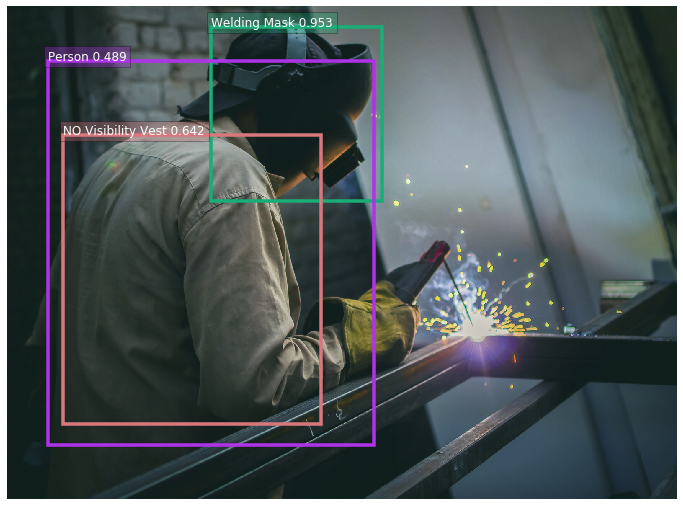

In [10]:
import matplotlib.pyplot as plt
from utils import visualize_detection

plt.rcParams['figure.figsize'] = [12, 12]
visualize_detection(file_name, result)

#### Deleting the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [11]:
sess.delete_endpoint(predictor.endpoint)

### Generate Prediction using Batch Transform

#### Uploading input data to S3

In [50]:
input_data_folder = 'batch_data/input'
s3_data_folder = 'ppe_model_batch_testing/input'

input_data_location = sess.upload_data(input_data_folder, key_prefix=s3_data_folder)
output_data_location = input_data_location.replace('input', 'output')

#### Starting a new Batch Transform Job

In [ ]:
transformer = model.transformer(instance_count=1,
                               instance_type='ml.m4.2xlarge',
                               output_path=output_data_location,
                               strategy='SingleRecord',
                               assemble_with=None,
                               accept='image/jpeg')

In [56]:
transformer.transform(input_data_location, 
    content_type='image/jpeg',
    compression_type=None,
    split_type=None,
    join_source=None)

transformer.wait()

#### Download and display the result file

In [41]:
output_file_name = '54_11.Welder_in_Egypt_(...jpg.out'
dest_path = 'data/test_samples/demo_raw_output/' + output_file_name
s3_path = 'ppe_model_batch_testing/output_v2/' + output_file_name

bucket = sess.boto_session.resource('s3').Bucket(sess.default_bucket())
bucket.download_file(s3_path, dest_path)

with open(dest_path, 'r') as file:
    print(file.read())

[[73.0, 226.0, 764.0, 1032.0, 0.8809224367141724, 0.9916692972183228, 4.0], [482.0, 68.0, 915.0, 427.0, 0.8395098447799683, 0.9984474778175354, 2.0], [65.0, 22.0, 895.0, 1096.0, 0.5797771215438843, 0.9999768733978271, 6.0]]
